# Project 4: Music Popularity Prediction


**Deep Dive Coding Data Science Bootcamp Sample Project**

---
Brannon Dugick April 25


## Problem Definition

This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.

The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project should be done using tree-based regression techniques as covered in class. The parameters of the trees should be carefully selected to avoid over-fitting.


There are two main challenges for this project:

1. Choosing appropriate predictors. When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.





## Data Collection/Sources

### Data Overview

### Imports

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb
import pickle
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from IPython.display import display
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score

### File Paths

File paths for train and test data.

In [2]:
base_path = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/'
train_path = base_path + 'Spotify.csv'
test_path = base_path + 'Spotify.csv'

### Load Data

Here we will load the data into a DataFrame and just take a look at the first few rows to make sure everything looks good.

In [3]:
train_orig = pd.read_csv(train_path)
train_orig.head()


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [4]:
train_orig.shape

(1556, 23)

In [5]:
train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [6]:
train_orig.describe().columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted'], dtype='object')

In [7]:
(
  train_orig
  .describe( include = "all" )
  .transpose()
  .astype({"count": int})
)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Index,1556,NaN,NaN,NaN,778.5,449.322824,1.0,389.75,778.5,1167.25,1556.0
Highest Charting Position,1556,NaN,NaN,NaN,87.744216,58.147225,1.0,37.0,80.0,137.0,200.0
Number of Times Charted,1556,NaN,NaN,NaN,10.66838,16.360546,1.0,1.0,4.0,12.0,142.0
Week of Highest Charting,1556,83,2019-12-27--2020-01-03,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song Name,1556,1556,Beggin',1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Streams,1556,1556,"48,633,449",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist,1556,716,Taylor Swift,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist Followers,1556,600,42227614,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song ID,1556,1517,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,1556,395,[],75,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train_orig.isnull()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1552,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1553,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1554,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
type(train_orig.isnull())

pandas.core.frame.DataFrame

In [10]:
train_orig.isnull().sum()

Index                        0
Highest Charting Position    0
Number of Times Charted      0
Week of Highest Charting     0
Song Name                    0
Streams                      0
Artist                       0
Artist Followers             0
Song ID                      0
Genre                        0
Release Date                 0
Weeks Charted                0
Popularity                   0
Danceability                 0
Energy                       0
Loudness                     0
Speechiness                  0
Acousticness                 0
Liveness                     0
Tempo                        0
Duration (ms)                0
Valence                      0
Chord                        0
dtype: int64

In [11]:
df = train_orig
df_info = pd.concat( [
  pd.DataFrame( [ df.isna().sum().to_dict() ], index = ["Nulls"] ).transpose().astype( { "Nulls": int } ),
  pd.DataFrame( [ df.dtypes.to_dict() ], index = [ "Data_Types"] ).transpose().astype( { "Data_Types": 'category' }),
  pd.DataFrame( [ df.memory_usage(deep=True, index = False).to_dict() ], index = ["Memory"] ).transpose(),
  df.describe( include = "all" ).transpose().astype( { "count": int } ).rename( columns = { "50%" : "median"} ),
], axis = "columns")
df_info["IRQ"] = df_info["75%"] - df_info["25%"]
df_info["range"] = df_info["max"] - df_info["min"]
df_info["sum"] = df_info["mean"] * df_info["count"]
df_info.insert( 1, "Nulls_pct" , round( df_info["Nulls"] / df_info.shape[0], 2) )


print( f"Memory: { (df_info['Memory'].sum() / 1000 / 1000 ):_} MB" )
print( df_info["Data_Types"].value_counts().to_json() )
df_info.sort_values(by = ["Data_Types", "max"], ascending=[1,0])


Memory: 2.499083 MB
{"object":20,"int64":3}


,Nulls,Nulls_pct,Data_Types,Memory,count,unique,top,freq,mean,std,min,25%,median,75%,max,IRQ,range,sum
Index,0,0.0,int64,12448,1556,NaN,NaN,NaN,778.5,449.322824,1.0,389.75,778.5,1167.25,1556.0,777.5,1555.0,1211346.0
Highest Charting Position,0,0.0,int64,12448,1556,NaN,NaN,NaN,87.744216,58.147225,1.0,37.0,80.0,137.0,200.0,100.0,199.0,136530.0
Number of Times Charted,0,0.0,int64,12448,1556,NaN,NaN,NaN,10.66838,16.360546,1.0,1.0,4.0,12.0,142.0,11.0,141.0,16600.0
Week of Highest Charting,0,0.0,object,122924,1556,83,2019-12-27--2020-01-03,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song Name,0,0.0,object,121165,1556,1556,Beggin',1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Streams,0,0.0,object,102801,1556,1556,"48,633,449",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist,0,0.0,object,111024,1556,716,Taylor Swift,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist Followers,0,0.0,object,99897,1556,600,42227614,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song ID,0,0.0,object,122693,1556,1517,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,0,0.0,object,149220,1556,395,[],75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No Nulls


## Data Cleaning

### Drop Columns

First, we'll drop a couple of columns that don't look useful.  
PassengerId is just an ID number assigned by counting up.  This won't help our model so we'll drop this column.
The passenger's name isn't going to help our predictions so we'll drop the name column too.  

In [12]:
train = train_orig.copy()
train.head()


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [13]:
train.drop('Index', axis=1, inplace=True)
train.drop('Song ID', axis=1, inplace=True)


Next, let's take a look at the ticket column and try to see if it will be useful. The data dictionary says that this will be the ticket number and it might not be helpful but we'll double check what is in there.

In [14]:
train.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Genre,Release Date,Weeks Charted,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [15]:
row_count = train.shape[0]
columns_with_zeroes = train.columns[(train == 0).any()]
zero_count = (train[columns_with_zeroes] == 0).sum()
zero_percent = (zero_count/row_count) * 100
zero_counts_df = pd.DataFrame({'Column': zero_count.index, 'Zero Count': zero_count.values, 'Zero Percent': zero_percent.values})
zero_counts_df.sort_values(by='Zero Percent', ascending=False)

,Column,Zero Count,Zero Percent


Look for Empty Strings

In [16]:
# Find empty strings using isna() or isnull()
empty_strings = train[train == ''].count()

# Display columns with empty strings and their counts
print(empty_strings[empty_strings > 0])


Series([], dtype: int64)


In [17]:
row_count = train.shape[0]
columns_with_empty_strings = train.columns[(train == '').any()]
empty_string_count = (train[columns_with_empty_strings] == '').sum()
empty_string_percent = (empty_string_count/row_count) * 100
empty_string_counts_df = pd.DataFrame({'Column': empty_string_count.index, 'Empty String Count': empty_string_count.values, 'Empty String Percent': empty_string_percent.values})
empty_string_counts_df.sort_values(by='Empty String Percent', ascending=False)


,Column,Empty String Count,Empty String Percent


In [18]:
# Find rows with empty strings
rows_with_empty_strings = train[train.apply(lambda row: row.astype(str).str.contains('', na=False)).any(axis=1)]

# Display rows with empty strings
print(rows_with_empty_strings)


      Highest Charting Position  Number of Times Charted  \
0                             1                        8   
1                             2                        3   
2                             1                       11   
3                             3                        5   
4                             5                        1   
...                         ...                      ...   
1551                        195                        1   
1552                        196                        1   
1553                        197                        1   
1554                        198                        1   
1555                        199                        1   

     Week of Highest Charting                           Song Name     Streams  \
0      2021-07-23--2021-07-30                             Beggin'  48,633,449   
1      2021-07-23--2021-07-30           STAY (with Justin Bieber)  47,248,719   
2      2021-06-25--2021-07-02       

In [19]:
empty_string_drop_df = train.copy()


In [20]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Danceability'] = empty_string_drop_df['Danceability'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Danceability'] = empty_string_drop_df['Danceability'].astype(float)


In [21]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Energy'] = empty_string_drop_df['Energy'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Energy'] = empty_string_drop_df['Energy'].astype(float)


In [22]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Loudness'] = empty_string_drop_df['Loudness'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Loudness'] = empty_string_drop_df['Loudness'].astype(float)


In [23]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Speechiness'] = empty_string_drop_df['Speechiness'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Speechiness'] = empty_string_drop_df['Speechiness'].astype(float)


In [24]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Acousticness'] = empty_string_drop_df['Acousticness'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Acousticness'] = empty_string_drop_df['Acousticness'].astype(float)


In [25]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Liveness'] = empty_string_drop_df['Liveness'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Liveness'] = empty_string_drop_df['Liveness'].astype(float)


In [26]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Tempo'] = empty_string_drop_df['Tempo'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Tempo'] = empty_string_drop_df['Tempo'].astype(float)


In [27]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Duration (ms)'] = empty_string_drop_df['Duration (ms)'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Duration (ms)'] = empty_string_drop_df['Duration (ms)'].astype(float)


In [28]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Valence'] = empty_string_drop_df['Valence'].replace(' ', 0)

# Convert 'Danceability' to float
empty_string_drop_df['Valence'] = empty_string_drop_df['Valence'].astype(float)


In [29]:

# Replace empty strings in 'Popularity' with NaN
empty_string_drop_df['Popularity'] = empty_string_drop_df['Popularity'].replace(' ', 0)

# Convert 'Popularity' to float first to handle NaNs
empty_string_drop_df['Popularity'] = empty_string_drop_df['Popularity'].astype(float)



In [30]:
# Convert 'Highest Charting Position' to int
empty_string_drop_df['Highest Charting Position'] = empty_string_drop_df['Highest Charting Position'].astype(int)


In [31]:
# Remove commas and convert 'Streams' to int
empty_string_drop_df['Streams'] = empty_string_drop_df['Streams'].str.replace(',', '').astype(int)


In [32]:
# Replace non-numeric values with 0 and convert 'Artist Followers' to int
empty_string_drop_df['Artist Followers'] = pd.to_numeric(empty_string_drop_df['Artist Followers'], errors='coerce').fillna(0).astype(int)


In [33]:
# Convert 'Song Name' to int
empty_string_drop_df['Song Name'] = empty_string_drop_df['Song Name'].astype(str)


In [34]:
# Convert 'Artist' to int
empty_string_drop_df['Artist'] = empty_string_drop_df['Artist'].astype(str)


In [35]:
empty_string_drop_df['Chord'].value_counts()

Chord
C#/Db    214
C        155
B        141
G        136
F        131
G#/Ab    130
D        125
A#/Bb    122
F#/Gb    121
A        118
E        112
D#/Eb     40
          11
Name: count, dtype: int64

Encode Chords

In [36]:
chord_mapping = {
    'C#/Db': 1,
    'C': 2,
    'B': 3,
    'G': 4,
    'F': 5,
    'G#/Ab': 6,
    'D': 7,
    'A#/Bb': 8,
    'F#/Gb': 9,
    'A': 10,
    'E': 11,
    'D#/Eb': 12
}

In [37]:
empty_string_drop_df['Chord_Encoded'] = empty_string_drop_df['Chord'].map(chord_mapping)


In [38]:

# Replace empty strings in 'Danceability' with NaN
empty_string_drop_df['Chord_Encoded'] = empty_string_drop_df['Chord_Encoded'].fillna(0)

# Convert 'Danceability' to float
empty_string_drop_df['Chord_Encoded'] = empty_string_drop_df['Chord_Encoded'].astype(float)


In [39]:
empty_string_drop_df.isna().sum()

Highest Charting Position    0
Number of Times Charted      0
Week of Highest Charting     0
Song Name                    0
Streams                      0
Artist                       0
Artist Followers             0
Genre                        0
Release Date                 0
Weeks Charted                0
Popularity                   0
Danceability                 0
Energy                       0
Loudness                     0
Speechiness                  0
Acousticness                 0
Liveness                     0
Tempo                        0
Duration (ms)                0
Valence                      0
Chord                        0
Chord_Encoded                0
dtype: int64

In [40]:
empty_string_drop_df['Release Date'].value_counts()

Release Date
2020-01-17    34
2020-02-14    28
2020-03-06    28
2021-06-25    27
2020-12-11    27
              ..
2020-11-07     1
2019-11-27     1
2020-05-19     1
2013-04-01     1
2019-09-25     1
Name: count, Length: 478, dtype: int64

Convert date into a ordinal number

force conversion

In [41]:
# Convert 'Release Date' to datetime format
empty_string_drop_df['Release_Date'] = pd.to_datetime(empty_string_drop_df['Release Date'], errors='coerce')


check for Not a timestamp values

In [42]:
# Check for NaT values in 'Release_Date' column
na_values = empty_string_drop_df['Release_Date'].isna().sum()

print(f"Number of NaT values in 'Release_Date': {na_values}")


Number of NaT values in 'Release_Date': 28


In [43]:
empty_string_drop_df['Artist'].value_counts()

Artist
Taylor Swift                     52
Lil Uzi Vert                     32
Justin Bieber                    32
Juice WRLD                       30
Pop Smoke                        29
                                 ..
Chris Brown, Young Thug           1
Rauw Alejandro, J Balvin          1
347aidan                          1
Migrantes, Alico                  1
Dadá Boladão, Tati Zaqui, OIK     1
Name: count, Length: 716, dtype: int64

Encoding Artist with their frequency count

In [44]:
artist_frequency = df['Artist'].value_counts().to_dict()
empty_string_drop_df['Artist_FrequencyEncoded'] = empty_string_drop_df['Artist'].map(artist_frequency)


look at distribution for imputation strategy

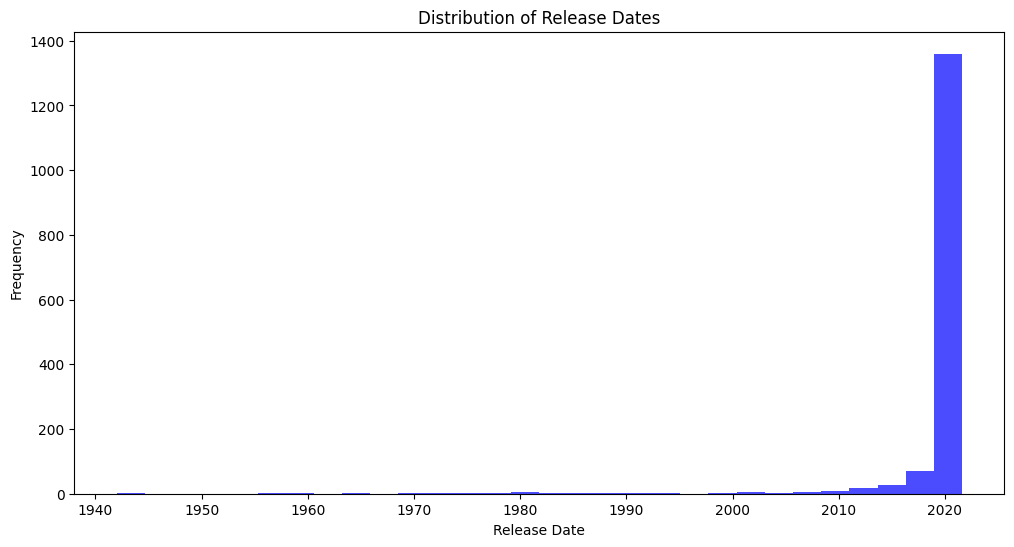

In [45]:


# Drop NaT values for plotting
release_date_no_na = empty_string_drop_df['Release_Date'].dropna()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(release_date_no_na, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Release Dates')
plt.xlabel('Release Date')
plt.ylabel('Frequency')
plt.show()


Use Mode based on distribution

In [46]:
# Calculate the mode of the 'Release_Date' column
mode_release_date = empty_string_drop_df['Release_Date'].mode()[0]

# Replace NaT values with the mode
empty_string_drop_df['Release_Date'].fillna(mode_release_date, inplace=True)


In [47]:
# Check for NaT values in 'Release_Date' column
na_values = empty_string_drop_df['Release_Date'].isna().sum()

print(f"Number of NaT values in 'Release_Date': {na_values}")


Number of NaT values in 'Release_Date': 0


In [48]:

# Convert to ordinal
empty_string_drop_df['Release_Date_Ordinal'] = empty_string_drop_df['Release_Date'].apply(lambda x: x.toordinal())


In [49]:
empty_string_drop_df['Genre'].value_counts()

Genre
[]                                                                                                   75
['dance pop', 'pop', 'post-teen pop']                                                                71
['latin', 'reggaeton', 'trap latino']                                                                63
['pop', 'post-teen pop']                                                                             57
['melodic rap', 'philly rap', 'rap', 'trap']                                                         33
                                                                                                     ..
['trap queen']                                                                                        1
['dream smp', 'viral rap']                                                                            1
['disco', 'europop', 'new romantic', 'new wave', 'new wave pop', 'soft rock', 'synthpop']             1
['adult standards', 'brill building pop', 'easy listening'

In [50]:
empty_string_drop_df['Week of Highest Charting'].value_counts()

Week of Highest Charting
2019-12-27--2020-01-03    89
2020-12-18--2020-12-25    68
2020-01-03--2020-01-10    51
2021-07-23--2021-07-30    46
2020-01-17--2020-01-24    39
                          ..
2021-01-22--2021-01-29     8
2020-12-25--2021-01-01     7
2020-10-09--2020-10-16     7
2020-12-04--2020-12-11     5
2021-02-19--2021-02-26     4
Name: count, Length: 83, dtype: int64

In [51]:
# Extract starting date from 'Week of Highest Charting'
empty_string_drop_df['Highest_Chart_Start_Date'] = empty_string_drop_df['Week of Highest Charting'].str.split('--').str[0]


In [52]:
empty_string_drop_df['Highest_Chart_Start_Date_Ordinal'] = pd.to_datetime(empty_string_drop_df['Highest_Chart_Start_Date']).apply(lambda x: x.toordinal())


In [53]:
empty_string_drop_df.drop('Highest_Chart_Start_Date', axis=1, inplace=True)


In [54]:
empty_string_drop_df.drop('Week of Highest Charting', axis=1, inplace=True)


In [55]:
empty_string_drop_df.drop('Release Date', axis=1, inplace=True)


Drop weeks charted as it does not aid in the prediction.

In [56]:
empty_string_drop_df.drop('Weeks Charted', axis=1, inplace=True)


In [57]:
empty_string_drop_df.drop('Chord', axis=1, inplace=True)


In [58]:
empty_string_drop_df.drop('Artist', axis=1, inplace=True)


In [59]:
empty_string_drop_df.head()

,Highest Charting Position,Number of Times Charted,Song Name,Streams,Artist Followers,Genre,Popularity,Danceability,Energy,Loudness,...,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_Encoded,Release_Date,Artist_FrequencyEncoded,Release_Date_Ordinal,Highest_Chart_Start_Date_Ordinal
0,1,8,Beggin',48633449,3377762,"['indie rock italiano', 'italian pop']",100.0,0.714,0.800,-4.808,...,0.1270,0.3590,134.002,211560.0,0.589,3.0,2017-12-08,4,736671,737994
1,2,3,STAY (with Justin Bieber),47248719,2230022,['australian hip hop'],99.0,0.591,0.764,-5.484,...,0.0383,0.1030,169.928,141806.0,0.478,1.0,2021-07-09,9,737980,737994
2,1,11,good 4 u,40162559,6266514,['pop'],99.0,0.563,0.664,-5.044,...,0.3350,0.0849,166.928,178147.0,0.688,10.0,2021-05-21,12,737931,737966
3,3,5,Bad Habits,37799456,83293380,"['pop', 'uk pop']",98.0,0.808,0.897,-3.712,...,0.0469,0.3640,126.026,231041.0,0.591,3.0,2021-06-25,9,737966,737973
4,5,1,INDUSTRY BABY (feat. Jack Harlow),33948454,5473565,"['lgbtq+ hip hop', 'pop rap']",96.0,0.736,0.704,-7.409,...,0.0203,0.0501,149.995,212000.0,0.894,12.0,2021-07-23,6,737994,737994


In [60]:
empty_string_drop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Highest Charting Position         1556 non-null   int64         
 1   Number of Times Charted           1556 non-null   int64         
 2   Song Name                         1556 non-null   object        
 3   Streams                           1556 non-null   int64         
 4   Artist Followers                  1556 non-null   int64         
 5   Genre                             1556 non-null   object        
 6   Popularity                        1556 non-null   float64       
 7   Danceability                      1556 non-null   float64       
 8   Energy                            1556 non-null   float64       
 9   Loudness                          1556 non-null   float64       
 10  Speechiness                       1556 non-null 

Convert Columns

In [61]:
 #Excluding two features for now. Genre will be a lot to one hot encode and song name seems to have no value on intuition and its low density cardniality
    #'Genre',
    #'Song Name',


selected_features_df = empty_string_drop_df[[
    'Highest Charting Position',
    'Number of Times Charted',
    'Streams',
    'Artist Followers',
    'Popularity',
    'Danceability',
    'Energy',
    'Loudness',
    'Speechiness',
    'Acousticness',
    'Liveness',
    'Tempo',
    'Duration (ms)',
    'Valence',
    'Chord_Encoded',
    'Release_Date_Ordinal',
    'Highest_Chart_Start_Date_Ordinal',
    'Artist_FrequencyEncoded'
]].copy()


In [62]:
selected_features_df

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_Encoded,Release_Date_Ordinal,Highest_Chart_Start_Date_Ordinal,Artist_FrequencyEncoded
0,1,8,48633449,3377762,100.0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,3.0,736671,737994,4
1,2,3,47248719,2230022,99.0,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,1.0,737980,737994,9
2,1,11,40162559,6266514,99.0,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,10.0,737931,737966,12
3,3,5,37799456,83293380,98.0,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,3.0,737966,737973,9
4,5,1,33948454,5473565,96.0,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,12.0,737994,737994,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,195,1,4630675,27167675,79.0,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,209320.0,0.608,10.0,736482,737420,15
1552,196,1,4623030,15019109,66.0,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,181930.0,0.714,3.0,737343,737420,3
1553,197,1,4620876,22698747,81.0,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,217307.0,0.394,7.0,736706,737420,4
1554,198,1,4607385,208630,60.0,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,152784.0,0.881,5.0,737327,737420,1


### Check target values

Since the survived column holds our target values, it's a good idea just to check and make sure that all of these values are valid.  

In [63]:
selected_features_df['Popularity'].value_counts()

Popularity
75.0    67
76.0    66
72.0    64
77.0    62
80.0    58
        ..
38.0     1
46.0     1
97.0     1
98.0     1
3.0      1
Name: count, Length: 69, dtype: int64


## Exploratory Data Analysis

### Feature Correlation

In [64]:
##sns.set()
##sns.pairplot(selected_features_df) ;

*It's important to note that Naive Bayes assumes that features are not correlated with each other.  Here we have several features which ARE highly correlated.  We will use Naive Bayes anyway and just see how it does.  However, it may not be the best model for this data set.*


## Data Processing

Split features and target

In [65]:
X = selected_features_df.drop('Popularity', axis = 1)
y = selected_features_df['Popularity']

###Decisions Tree

In [66]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 9.09


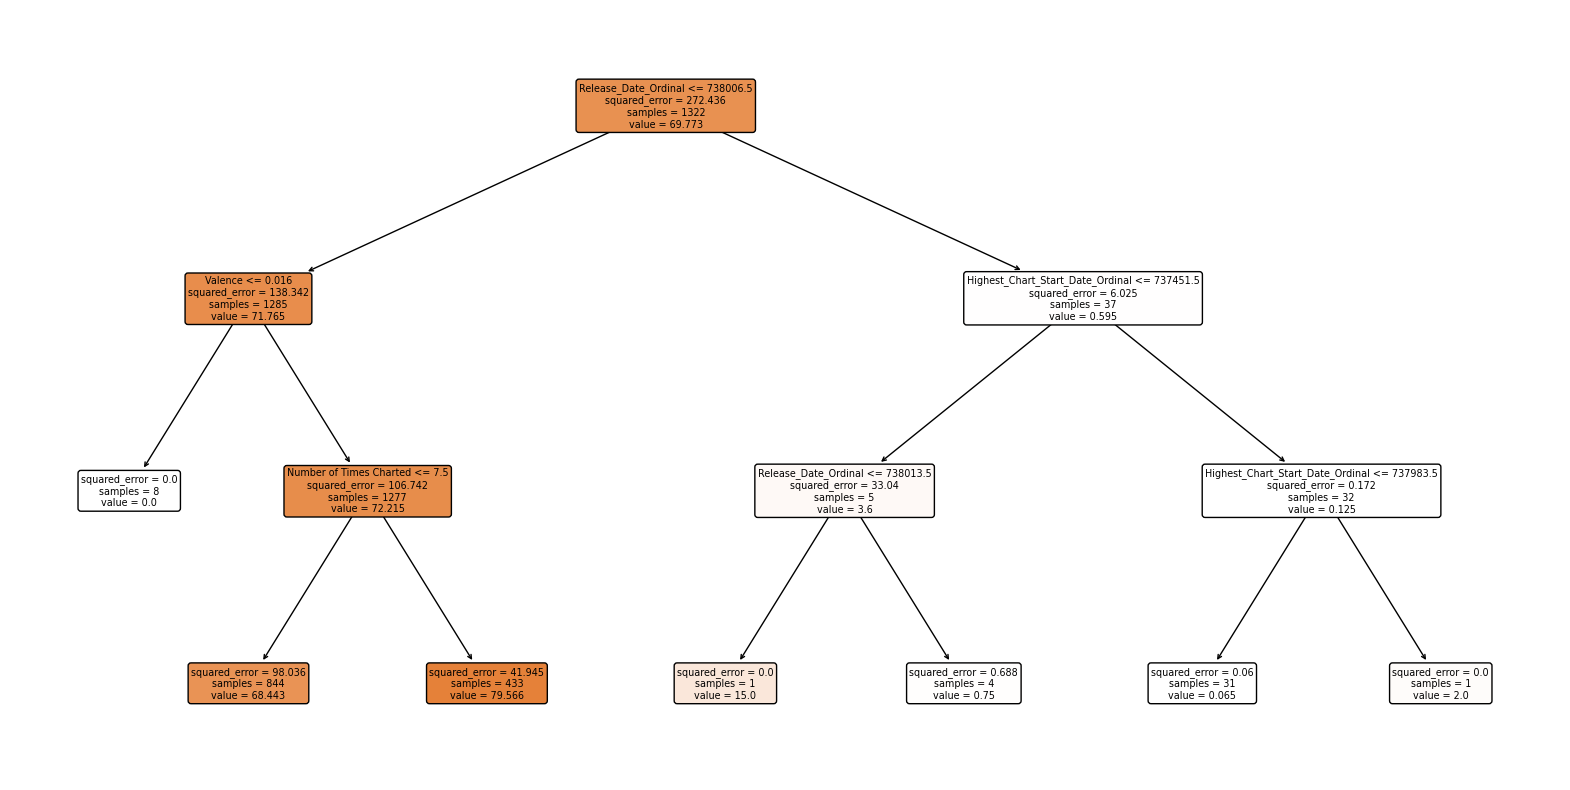

In [88]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True)
plt.show()

## Find Important Predictors

###Random Forest

In [67]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:50]


RMSE: 5.216342441103472
RMSE_std: 0.4747032797541382


array([4.77253763, 5.21718069, 4.41335749, 4.66747131, 4.93220708,
       5.13934047, 5.90348658, 5.64069179, 5.06983601, 5.81086515,
       5.45587192, 4.76711828, 5.50558574, 4.38282268, 5.04308679,
       4.90622642, 5.29687257, 4.65856325, 5.13002412, 5.50217323,
       5.63492714, 5.01489768, 4.85634663, 5.63139096, 4.70122393,
       5.72145086, 4.98336013, 4.84966295, 5.30131515, 4.90945255,
       5.24225314, 5.03728725, 4.88144052, 4.97362273, 5.41069395,
       4.79102727, 4.38108185, 5.7400555 , 5.52660523, 5.30019049,
       5.68461994, 7.05061827, 4.86661837, 5.90543264, 5.71966917,
       4.87566564, 4.96243905, 5.75398691, 4.81490741, 6.99350202])

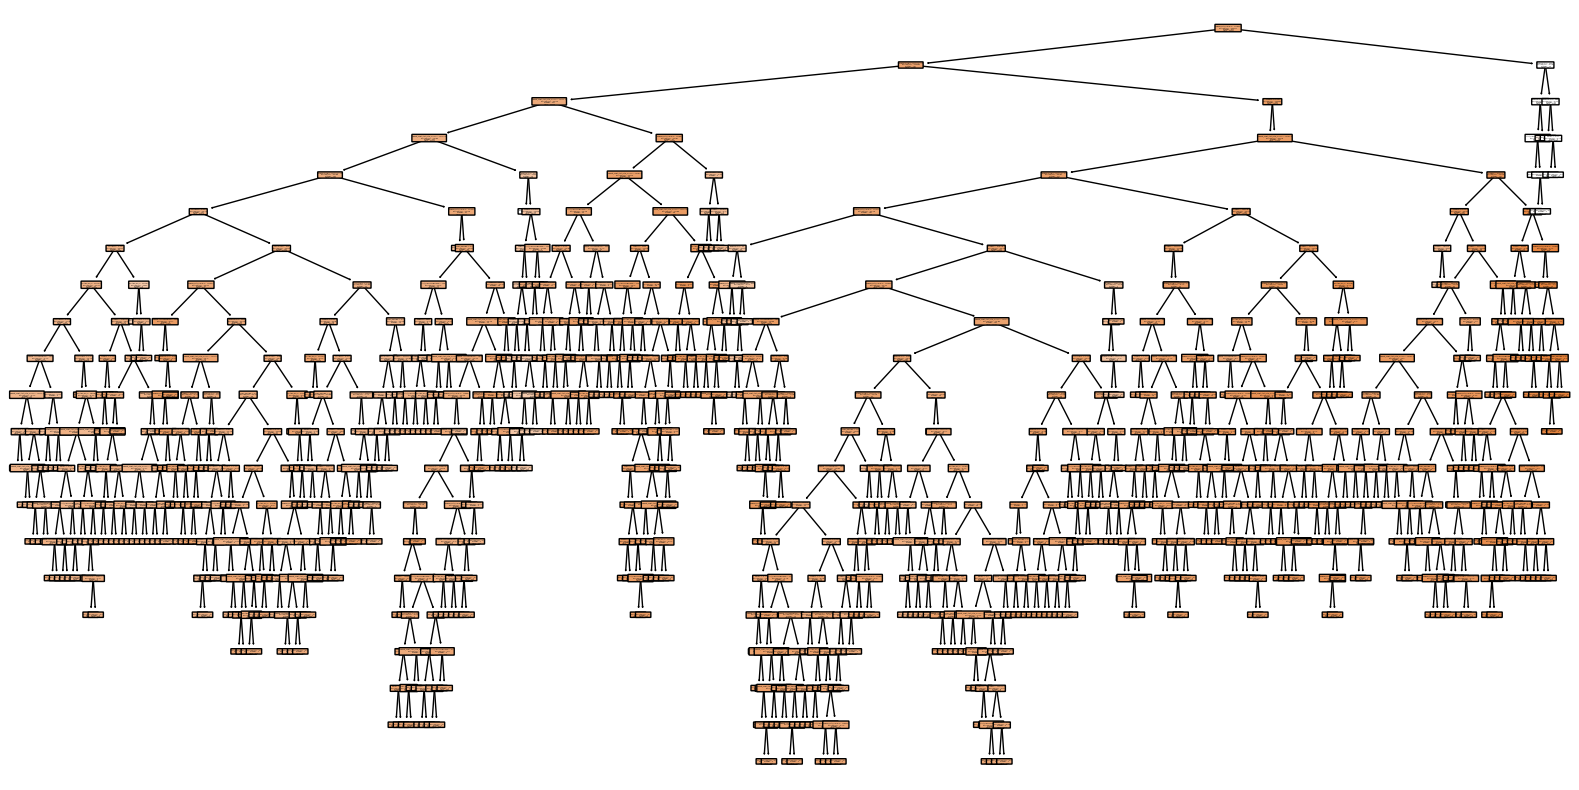

In [89]:
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)

# Visualize one of the trees (e.g., the first tree)
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True, rounded=True)
plt.show()

###XGBoost

In [68]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 5.091400807819812


Pretty good RMSE with XGBOOST without tuning.

In [69]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}


Best hyper parameters.
'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}


In [71]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.1,
      max_depth = 6,
      n_estimators = 60,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 4.839432752438324


BEST RMSE

<Figure size 2000x1000 with 0 Axes>

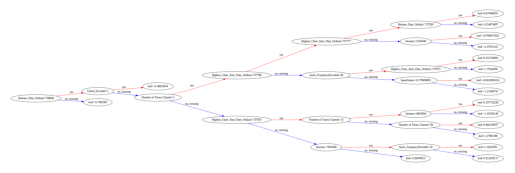

In [115]:

# Visualize the first tree in the XGBoost model
plt.figure(figsize=(20, 10))
xgb.plot_tree(xgbr, num_trees=0, rankdir='LR')
plt.show()

<Figure size 2000x1000 with 0 Axes>

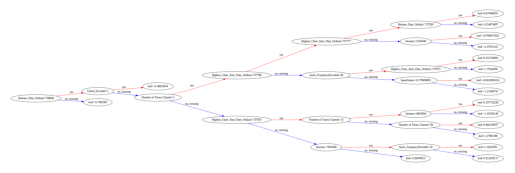

In [117]:
# Visualize the first tree in the XGBoost model
plt.figure(figsize=(20, 10))
xgb.plot_tree(xgbr, num_trees=0, rankdir='LR')

# Save the plot as an image file
plt.savefig('xgboost_first_tree.png')

plt.show()


<ipython-input-90-16d4b8a6cfd6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


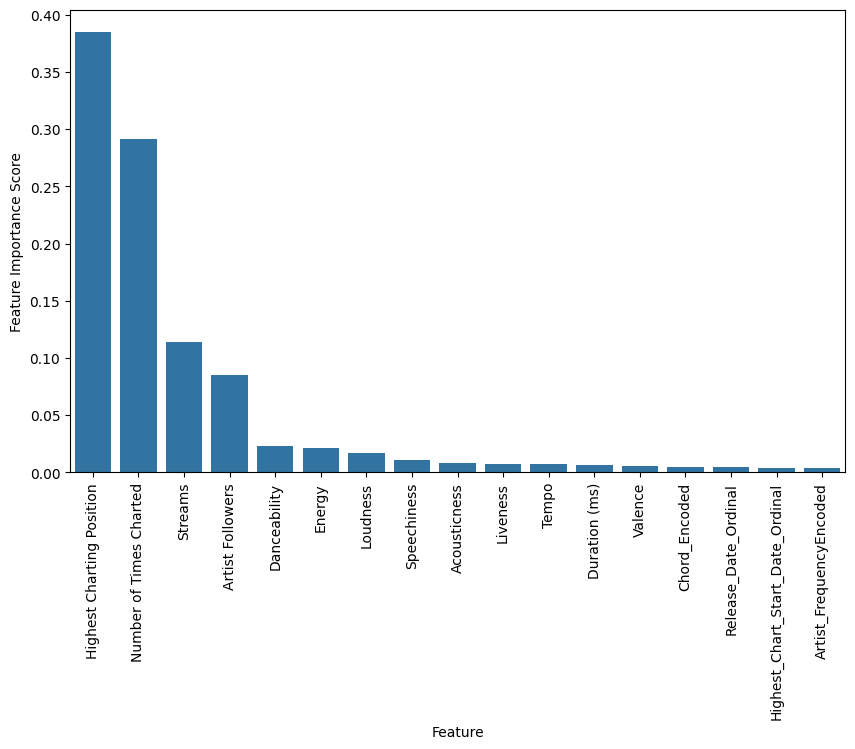

In [90]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;

Wide open with all features.

##RETRY

Reducing dataframe and rerunning with optimal params from before


In [93]:

selected_features_df_revised = empty_string_drop_df[[
    'Highest Charting Position',
    'Number of Times Charted',
    'Streams',
    'Artist Followers',
    'Popularity',
    'Danceability',
    'Energy',
    'Loudness',
    'Speechiness'
]].copy()


In [95]:
X2 = selected_features_df_revised.drop('Popularity', axis = 1)
y2 = selected_features_df_revised['Popularity']

In [96]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.1,
      max_depth = 6,
      n_estimators = 60,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 9.43749345310785


Worse RMSE

<ipython-input-97-16d4b8a6cfd6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


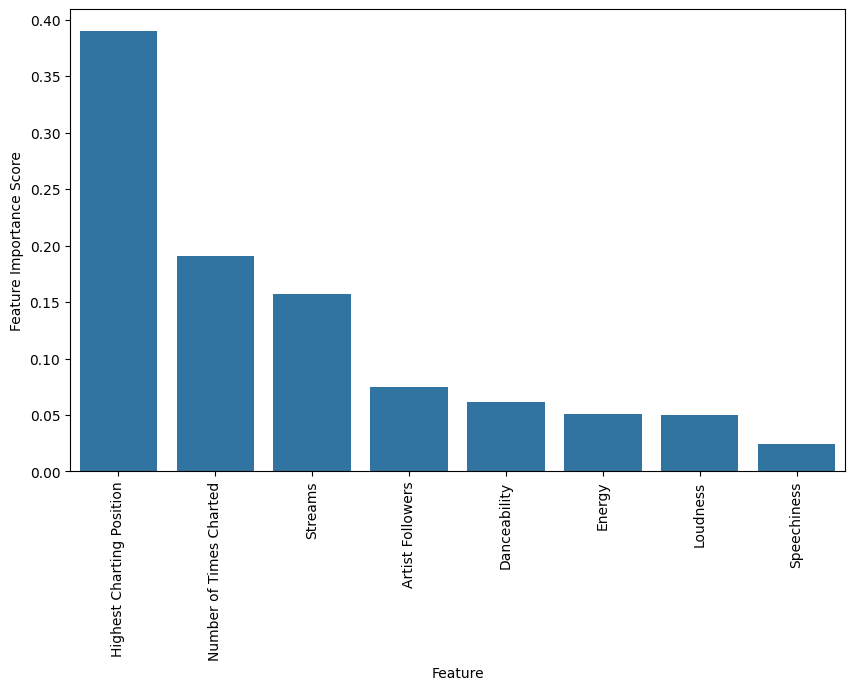

In [97]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;

<Figure size 2000x1000 with 0 Axes>

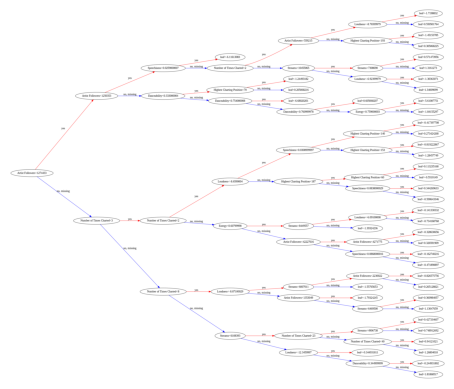

In [98]:
# Visualize the first tree in the XGBoost model
plt.figure(figsize=(20, 10))
xgb.plot_tree(xgbr, num_trees=0, rankdir='LR')
plt.show()

Try Random Forest

In [100]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:50]


RMSE: 9.023131997585315
RMSE_std: 0.9613795071230485


array([ 7.93495593,  9.58619968,  9.43661207, 10.76357223,  9.18766941,
        8.02997789,  8.79602912,  8.93898836,  9.28937738,  8.36609841,
        7.86143826, 10.43335228, 10.85548278,  7.18274062,  8.91324101,
        7.76844373,  7.72688032,  8.93834472,  9.05803405,  7.7844849 ,
        7.79136192, 10.41443463, 11.30357755,  8.6022228 ,  8.9422542 ,
        9.21210881,  9.96741004,  9.32551642,  9.15370704,  9.00632257,
        9.57003537,  9.3602799 ,  8.91005086,  9.9209003 ,  8.86079488,
        9.43502578,  6.94842031,  8.96135578,  8.75363111,  9.09815598,
       10.56560093,  8.66209877,  8.92118266,  8.64180359,  9.75100751,
       12.34544061,  8.78698776, 10.62068917,  7.86065136, 10.09272555])

##Retry 2
Gunna see if a hyper parameter tuning helps.

In [101]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 80}


Auto tuned hyper parameters

In [ ]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.3,
      max_depth = 3,
      n_estimators = 80,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

Rerun with new params

In [102]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X2, y2, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.1,
      max_depth = 6,
      n_estimators = 60,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 9.265400586993684


Negligible difference

Cross Validate original model with K folds.

Mean RMSE: 4.871100986997089
Std RMSE: 0.5857337580111533


<ipython-input-111-24ba05811a26>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


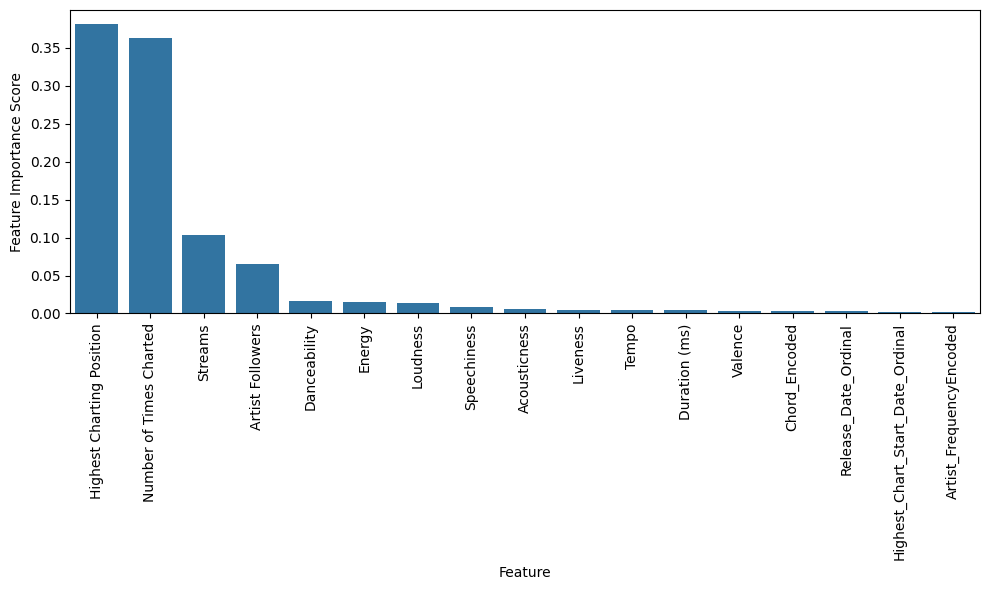

In [111]:
X = selected_features_df.drop('Popularity', axis = 1)
y = selected_features_df['Popularity']

# Define the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize MSE array
mse_xgb = np.zeros(num_folds)

# Define XGBoost model
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    verbosity=0,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=60,
    seed=10,
)

# Perform cross-validation
for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgbr.fit(X_train, y_train)
    y_pred_xgb = xgbr.predict(X_test)
    mse_xgb[idx] = mean_squared_error(y_test, y_pred_xgb)

# Convert MSE to RMSE
rmse_xgb = np.sqrt(mse_xgb)

# Print mean and standard deviation of RMSE scores
print("Mean RMSE:", rmse_xgb.mean())
print("Std RMSE:", rmse_xgb.std())

# Plot feature importance
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize=(10,6))
ax = sns.barplot(x=feat_imp.index, y=feat_imp.sort_values(ascending=False).values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

#Conlusion-

Original train data frame was overall most performant with these features

    'Highest Charting Position',
    'Number of Times Charted',
    'Streams',
    'Artist Followers',
    'Popularity',
    'Danceability',
    'Energy',
    'Loudness',
    'Speechiness',
    'Acousticness',
    'Liveness',
    'Tempo',
    'Duration (ms)',
    'Valence',  
    'Chord_Encoded',
    'Release_Date_Ordinal',
    'Highest_Chart_Start_Date_Ordinal',
    'Artist_FrequencyEncoded'

I can predict with a 4.5 margin of error within .5 standard deviation.


Popularity is a good target.

In the ends XGBoost was the most Performant
